# 291 Final Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from iminuit import Minuit
import emcee

# 1. Convert CSV to energy spectra

In [2]:
detA = pd.read_csv("./data/DetectorA.csv", header=None, names=["event_id", "class_score", "energy"])
detB = pd.read_csv("./data/DetectorB.csv", header=None, names=["event_id", "class_score", "energy"])
detC = pd.read_csv("./data/DetectorC.csv", header=None, names=["event_id", "class_score", "energy"])
detTarget = pd.read_csv("./data/DetectorTarget.csv", header=None, names=["event_id", "class_score", "energy"])

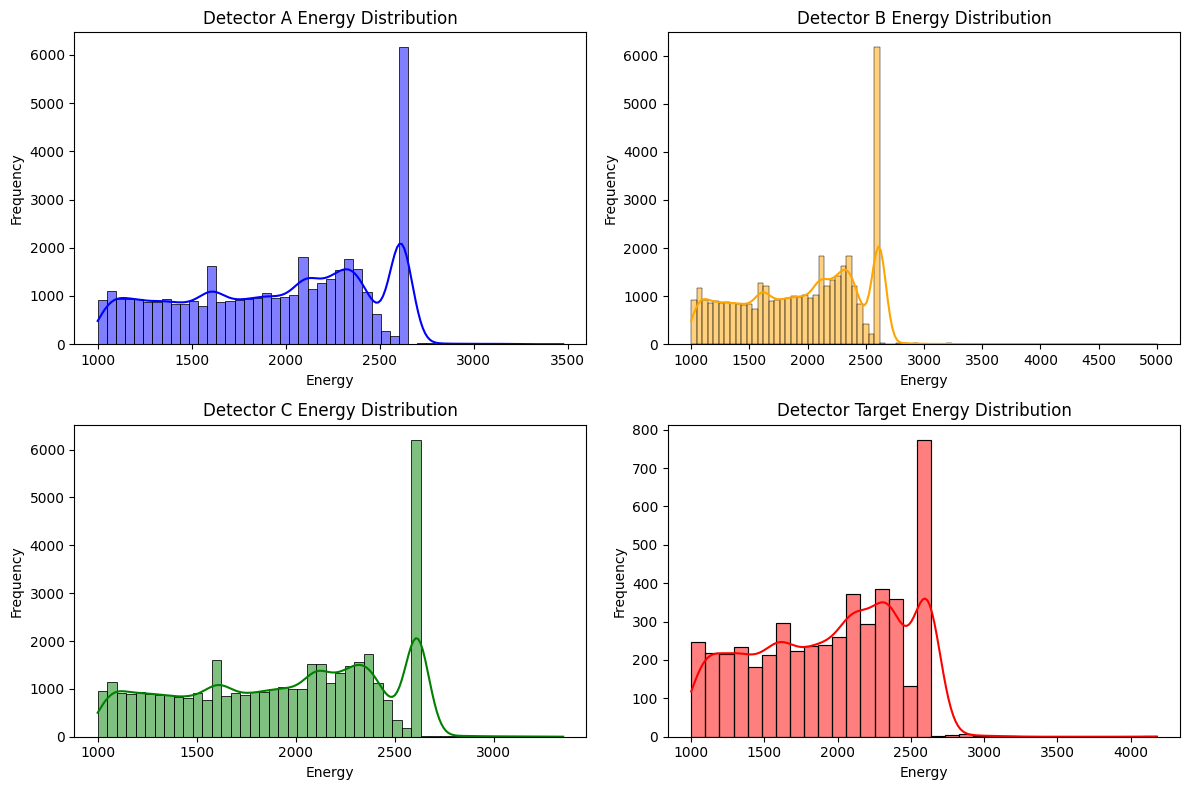

In [3]:
# plot histogram of energy for each detector
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.histplot(detA['energy'], kde=True, color='blue')
plt.title('Detector A Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 2)
sns.histplot(detB['energy'], kde=True, color='orange')
plt.title('Detector B Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 3)
sns.histplot(detC['energy'], kde=True, color='green')
plt.title('Detector C Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.subplot(2, 2, 4)
sns.histplot(detTarget['energy'], kde=True, color='red')
plt.title('Detector Target Energy Distribution')
plt.xlabel('Energy')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

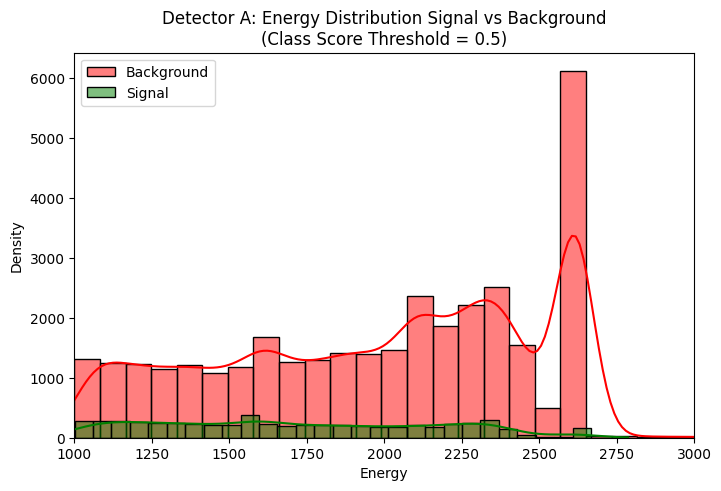

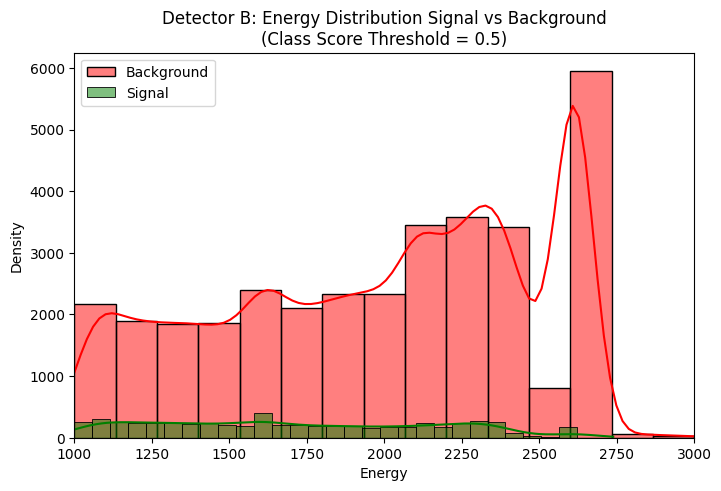

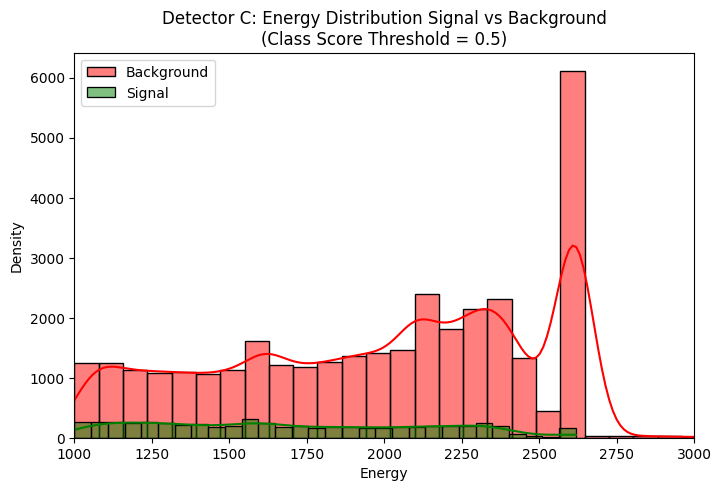

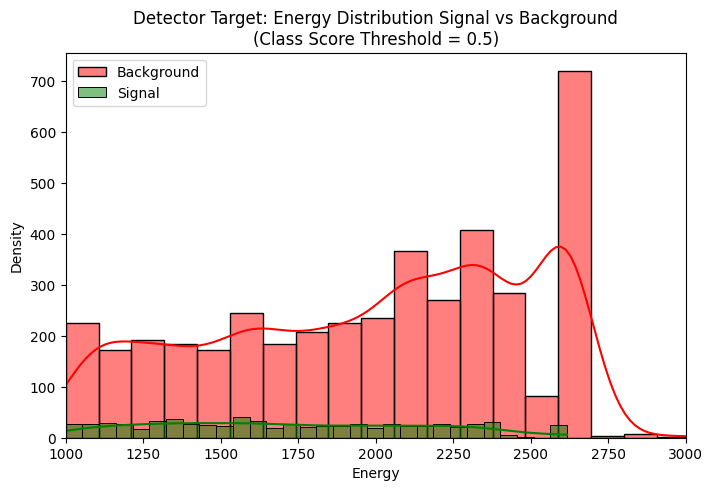

In [4]:
def split_plot(data, name, thresh=0.5, bins=30):
    detSignal = data[data['class_score'] > thresh]
    detBackground = data[data['class_score'] <= thresh]
    plt.figure(figsize=(8, 5))
    sns.histplot(detBackground['energy'], color='red', label='Background', kde=True, bins=bins)
    sns.histplot(detSignal['energy'], color='green', label='Signal', kde=True, bins=bins)
    plt.title(f'{name}: Energy Distribution Signal vs Background\n(Class Score Threshold = {thresh})')
    plt.xlabel('Energy')
    plt.xlim(1000, 3000)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

split_plot(detA, 'Detector A', 0.5)
split_plot(detB, 'Detector B', 0.5)
split_plot(detC, 'Detector C', 0.5)
split_plot(detTarget, 'Detector Target', 0.5)

# 2. Use 1592 keV peak in Detector A to set a cutting threshold

Evaluate true positive rate

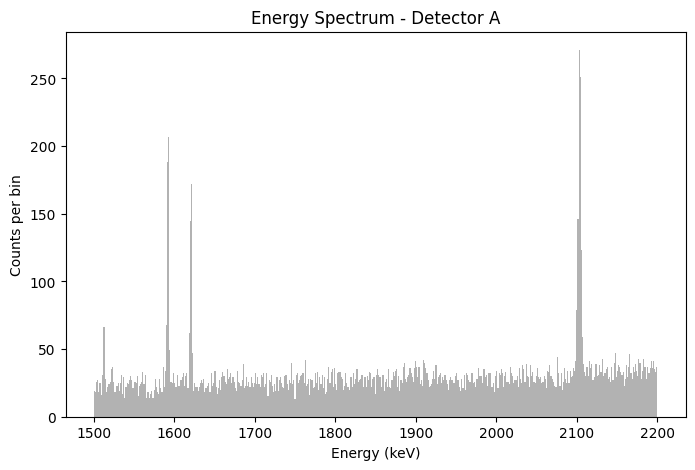

In [5]:
# Energy range for the spectrum (keV)
energy_min = 1500
energy_max = 2200
n_bins = 500  # adjust for resolution

# Histogram
counts, bin_edges = np.histogram(detA['energy'], bins=n_bins, range=(energy_min, energy_max))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Plot
plt.figure(figsize=(8,5))
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.6, color='gray')
plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector A")
plt.show()

In [6]:
delta = 20
signal = 1592
background = 2103
A_signal = detA[(detA["energy"] >= signal - delta) & (detA["energy"] <= signal + delta)]
A_background = detA[(detA["energy"] >= background - delta) & (detA["energy"] <= background + delta)]

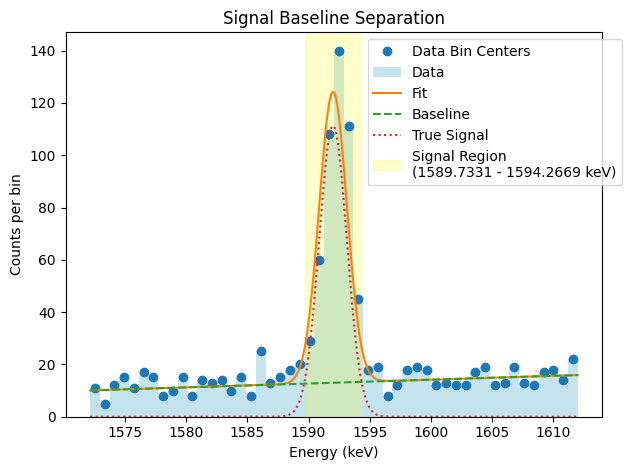

Fit results:
A = 139.56382222225528
mu = 1592.0
sigma = 1.1334474236858578
a = 16.289393676449897
b = 0.18488645067756196


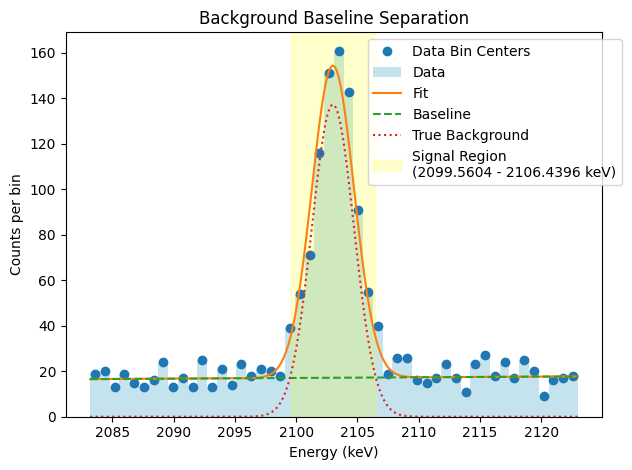

Fit results:
A = 172.4185014187384
mu = 2103.0
sigma = 1.7197990866196888
a = 21.52476658548735
b = 0.037850434368636575


In [7]:
def fit_signal_background(data, n_bins, mu, name):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    bin_width = (bin_edges[-1] - bin_edges[0]) / n_bins
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    def fit_function(x, A, mu, sigma, a, b):
        signal = A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
        background = a + b * (x - mu)
        return signal + background

    # Define the chi-square function to minimize.
    def chi2(A, mu, sigma, a, b):
        expected = fit_function(bin_centers, A, mu, sigma, a, b) * bin_width
        mask = counts > 0
        return np.sum(((counts[mask] - expected[mask])**2) / counts[mask])
    
    # Implement the Minuit fitting below
    m = Minuit(chi2, A=np.max(counts) * bin_width, mu=mu, sigma=1, a=np.mean(counts) / bin_width, b=0)
    m.limits["A"] = (0, None)
    m.limits["sigma"] = (0, None)
    m.limits["a"] = (0, None)
    m.fixed["mu"] = True
    m.migrad()
    A_fit, mu_fit, sigma_fit, a_fit, b_fit = m.values["A", "mu", "sigma", "a", "b"]

    # Calculate Signal and Background counts in the signal region
    signal_region_min = mu_fit - 2 * sigma_fit
    signal_region_max = mu_fit + 2 * sigma_fit
    # signal_region = (bin_centers >= signal_region_min) & (bin_centers <= signal_region_max)

    # all_signals = np.sum(counts[signal_region])
    # backgrounds = np.sum(fit_function(bin_centers[signal_region], 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width)
    # signals = all_signals - backgrounds

    m_fine = np.linspace(min(data), max(data), 1000)
    plt.plot(bin_centers, counts, 'o', label='Data Bin Centers')
    plt.hist(data, bins=n_bins, alpha=0.7, 
             label='Data', color='lightblue', density=False)
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '-', label='Fit')
    plt.plot(m_fine, fit_function(m_fine, 0, mu_fit, sigma_fit, a_fit, b_fit) * bin_width, '--', label='Baseline')
    plt.plot(m_fine, fit_function(m_fine, A_fit, mu_fit, sigma_fit, 0, 0) * bin_width, ':', label=f'True {name}')
    plt.axvspan(signal_region_min, signal_region_max, alpha=0.2, color='yellow', 
                label=f'Signal Region\n({signal_region_min:.4f} - {signal_region_max:.4f} keV)')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts per bin')
    plt.legend(loc="upper right", bbox_to_anchor=(1.05, 1))
    plt.title(f"{name} Baseline Separation")
    plt.tight_layout()
    plt.show()

    print(f"Fit results:")
    print(f"A = {A_fit}")
    print(f"mu = {mu_fit}")
    print(f"sigma = {sigma_fit}")
    print(f"a = {a_fit}")
    print(f"b = {b_fit}")

    return signal_region_min, signal_region_max

true_signal_min, true_signal_max = fit_signal_background(A_signal["energy"].values, n_bins=50, mu=signal, name="Signal")
true_background_min, true_background_max = fit_signal_background(A_background["energy"].values, n_bins=50, mu=background, name="Background")

In [8]:
# signal is 1592 peak. bkg is 2103 peak
true_A_signal_energy = A_signal[(A_signal["energy"] >= true_signal_min) & 
                                (A_signal["energy"] <= true_signal_max)]
true_A_background_energy = A_background[(A_background["energy"] >= true_background_min) & 
                                        (A_background["energy"] <= true_background_max)]
B_signal_energy = detB[(detB["energy"] >= true_signal_min) & 
                       (detB["energy"] <= true_signal_max)]
B_background_energy = detB[(detB["energy"] >= true_background_min) & 
                           (detB["energy"] <= true_background_max)]
C_signal_energy = detC[(detC["energy"] >= true_signal_min) & 
                       (detC["energy"] <= true_signal_max)]
C_background_energy = detC[(detC["energy"] >= true_background_min) & 
                           (detC["energy"] <= true_background_max)]
target_signal_energy = detTarget[(detTarget["energy"] >= true_signal_min) & 
                                 (detTarget["energy"] <= true_signal_max)]
target_background_energy = detTarget[(detTarget["energy"] >= true_background_min) & 
                                     (detTarget["energy"] <= true_background_max)]

In [9]:
signal_sigma = (true_signal_max - true_signal_min) / 4
background_sigma = (true_background_max - true_background_min) / 4 
signal_region = (
    (bin_centers >= (signal - 2*signal_sigma)) & (bin_centers <= (signal + 2*signal_sigma)) # Signal region is 2 sigma around peak
)
signal_sideband = (
    ((bin_centers >= (signal - 5*signal_sigma)) & (bin_centers <= (signal - 3*signal_sigma))) | # Sidebands are 1 sigma away from peak edges
    ((bin_centers >= (signal + 3*signal_sigma)) & (bin_centers <= (signal + 5*signal_sigma)))
)

N_s = counts[signal_region].sum() # Total counts in signal region
B_sig = counts[signal_sideband].sum() # Background in sidebands

background_sigma = (true_background_max - true_background_min) / 4
background_region = (
    (bin_centers >= (background - 2*background_sigma)) & (bin_centers <= (background + 2*background_sigma)) # Background region is 2 sigma around peak
)
background_sideband = (
    ((bin_centers >= (background - 5*background_sigma)) & (bin_centers <= (background - 3*background_sigma))) | # Sidebands are 1 sigma away from peak edges
    ((bin_centers >= (background + 3*background_sigma)) & (bin_centers <= (background + 5*background_sigma)))
)
N_b = counts[background_region].sum() # Total counts in background region
B_bkg = counts[background_sideband].sum() # Background in sidebands
tau = 1

Best threshold = 0.101
TPR at best threshold = 0.846
FPR at best threshold = 0.138


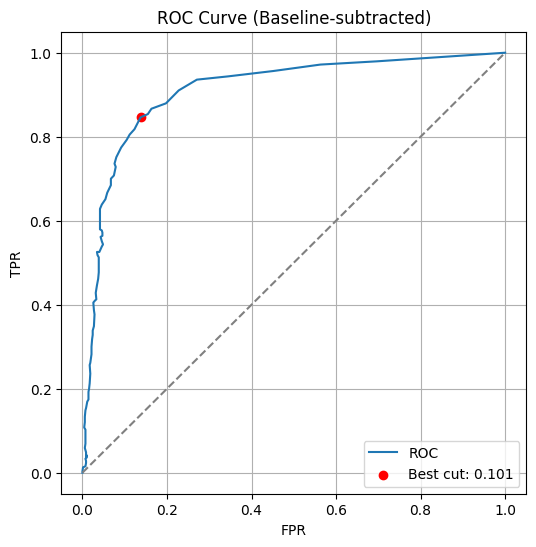

In [10]:
thresholds = np.linspace(0, 1, 100)
tprs = []
fprs = []

for t in thresholds:
    cut = detA['class_score'] >= t
    counts_cut = np.histogram(detA[cut]['energy'], bins=bin_edges, range=(energy_min, energy_max))[0]
    Nc_sig = counts_cut[signal_region].sum()
    Bc_sig = counts_cut[signal_sideband].sum()
    Nc_bkg = counts_cut[background_region].sum()
    Bc_bkg = counts_cut[background_sideband].sum()
    
    TPR = max(0, min(1, (Nc_sig - tau * Bc_sig) / (N_s - tau * B_sig))) ### Using baseline subtracted cut efficiency at signal peak for TPR
    FPR = max(0, min(1, (Nc_bkg - tau * Bc_bkg) / (N_b - tau * B_bkg))) #### Using baseline subtracted cut efficiency at background peak for FPR

    tprs.append(TPR)
    fprs.append(FPR)
    # print(TPR, FPR)

tprs = np.array(tprs)
fprs = np.array(fprs)
best_idx = np.argmax(tprs - fprs)
best_threshold = thresholds[best_idx]
THRESHOLD = best_threshold
best_TPR = tprs[best_idx]
best_FPR = fprs[best_idx]

print(f"Best threshold = {best_threshold:.3f}")
print(f"TPR at best threshold = {best_TPR:.3f}")
print(f"FPR at best threshold = {best_FPR:.3f}")

# Optional: plot ROC with best point highlighted
plt.figure(figsize=(6,6))
plt.plot(fprs, tprs, label="ROC")
plt.scatter(best_FPR, best_TPR, color='red', label=f"Best cut: {best_threshold:.3f}")
plt.plot([0,1],[0,1], linestyle="--", color="gray")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Baseline-subtracted)")
plt.grid()
plt.legend()
plt.show()

# 3. Evaluate and optimize cut against 2103 keV peak in detector B

Detector A, TPR: 0.8115942028985508, FPR: 0.20512820512820512


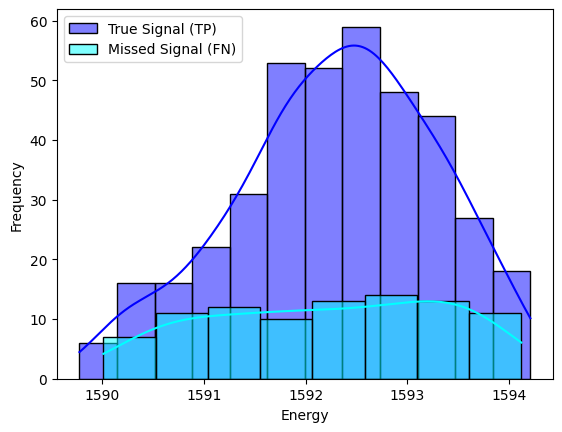

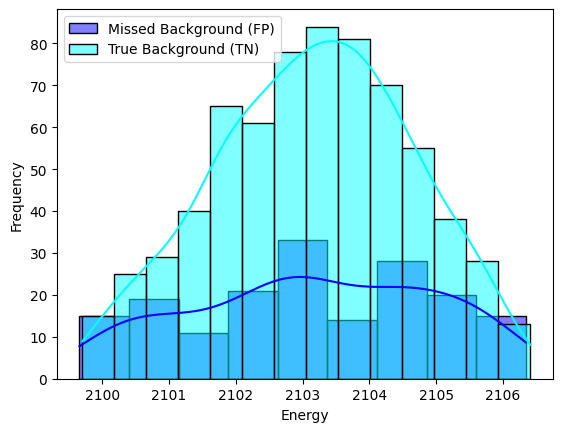

Detector B, TPR: 0.8053830227743272, FPR: 0.21839080459770116


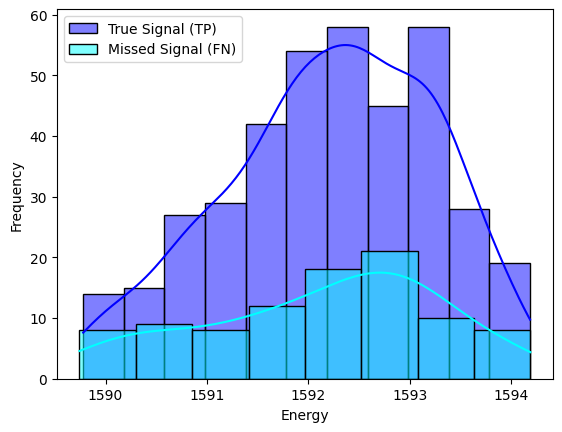

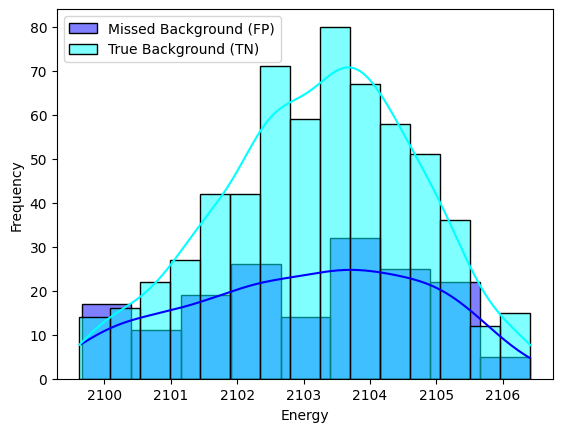

Detector C, TPR: 0.7750556792873051, FPR: 0.20204313280363223


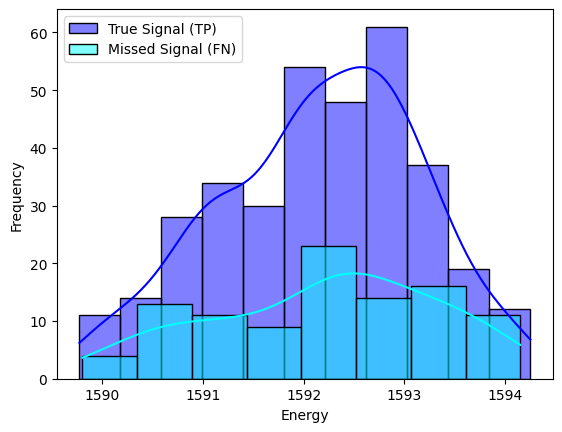

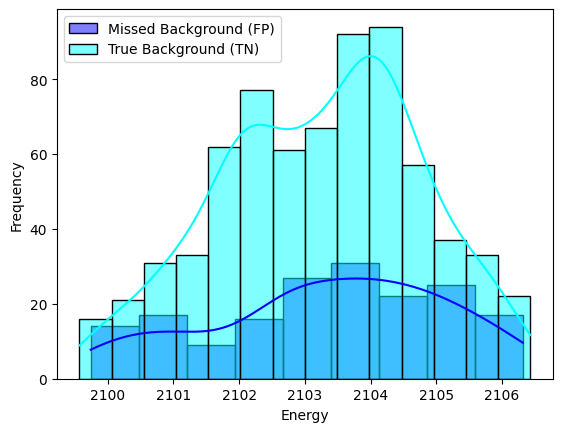

Detector Target, TPR: 0.8421052631578947, FPR: 0.20588235294117646


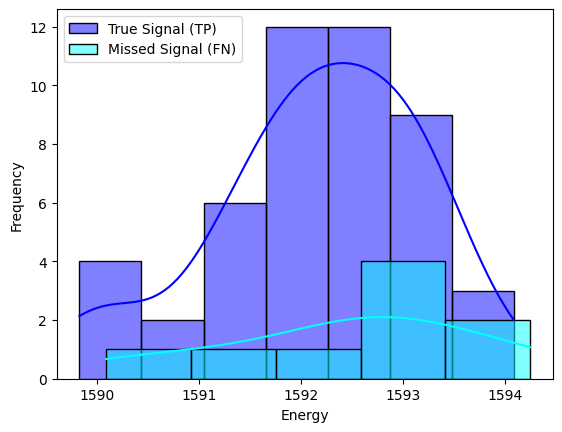

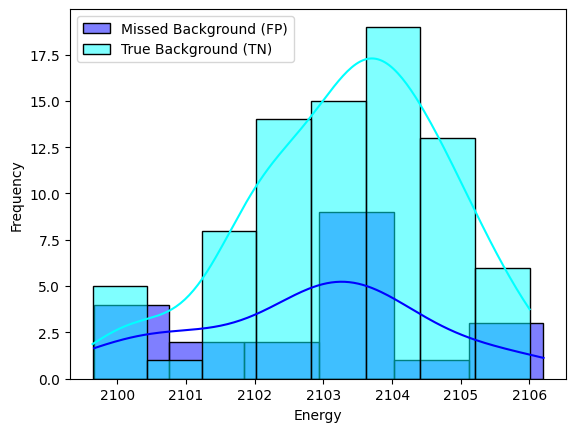

In [11]:
def eval_threshold(signal, background, threshold, name):
    tp = np.sum((signal['class_score'] >= threshold))
    fp = np.sum((background['class_score'] >= threshold))
    fn = np.sum((signal['class_score'] < threshold))
    tn = np.sum((background['class_score'] < threshold))
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"Detector {name}, TPR: {tpr}, FPR: {fpr}")
    sns.histplot(signal[signal['class_score'] >= threshold]['energy'], color='blue', label='True Signal (TP)', kde=True)
    sns.histplot(signal[signal['class_score'] < threshold]['energy'], color='cyan', label='Missed Signal (FN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()
    sns.histplot(background[background['class_score'] >= threshold]['energy'], color='blue', label='Missed Background (FP)', kde=True)
    sns.histplot(background[background['class_score'] < threshold]['energy'], color='cyan', label='True Background (TN)', kde=True)
    plt.xlabel("Energy")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

eval_threshold(true_A_signal_energy, true_A_background_energy, THRESHOLD, 'A')
eval_threshold(B_signal_energy, B_background_energy, THRESHOLD, 'B')
eval_threshold(C_signal_energy, C_background_energy, THRESHOLD, 'C')
eval_threshold(target_signal_energy, target_background_energy, THRESHOLD, 'Target')
    

In [12]:
optimal_cut = detA['class_score'] >= best_threshold
cut_counts, bin_edges_optimal = np.histogram(detA[optimal_cut]['energy'], bins=n_bins, range=(energy_min, energy_max))
cut_bin_centers = 0.5 * (bin_edges_optimal[1:] + bin_edges_optimal[:-1])

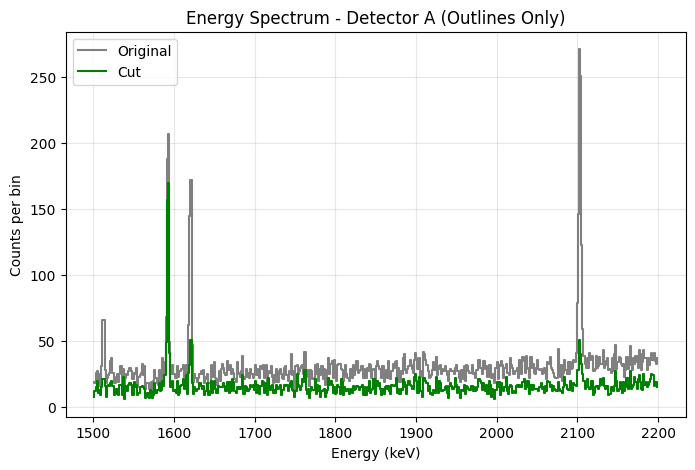

In [13]:
plt.figure(figsize=(8,5))

# Original histogram (outline)
plt.step(bin_centers, counts, where='mid', color='gray', label='Original')

# Filtered histogram (outline)
plt.step(cut_bin_centers, cut_counts, where='mid', color='green', label='Cut')

plt.xlabel("Energy (keV)")
plt.ylabel("Counts per bin")
plt.title("Energy Spectrum - Detector A (Outlines Only)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# 4. Generate model PDF for NLDBD with peak at 2039 keV peak $\pm$1 
# 5. Apply cut and generate PDFs of detectors ABC and target histogram

In [14]:
### Generate PDF for each detector after cut
energy_min = 1500
energy_max = 2200
n_bins = 1000  # adjust for resolution

### Applyign cut to all three detectors
detA_cut = detA[detA['class_score'] >= best_threshold]
detB_cut = detB[detB['class_score'] >= best_threshold]
detC_cut = detC[detC['class_score'] >= best_threshold]
detTarget_cut = detTarget[detTarget['class_score'] >= best_threshold]

detA_counts, bin_edges_A = np.histogram(detA_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detB_counts, bin_edges_B = np.histogram(detB_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detC_counts, bin_edges_C = np.histogram(detC_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
detTarget_counts, bin_edges_D = np.histogram(detTarget_cut['energy'], bins=n_bins, range=(energy_min, energy_max))
bin_centers = 0.5 * (bin_edges_A[:-1] + bin_edges_A[1:])


In [15]:
# Bin width (same for all since bins are identical)
bin_width = bin_edges_A[1] - bin_edges_A[0]

# Convert counts → PDF
pdf_A = detA_counts / (detA_counts.sum() * bin_width)
pdf_B = detB_counts / (detB_counts.sum() * bin_width)
pdf_C = detC_counts / (detC_counts.sum() * bin_width)
# pdf_D = detTarget    / (detTarget.sum()    * bin_width)/


In [16]:
### Generate PDF for 0vbb

mu = 2039
sigma = 1
n_events = 10000

# Generate Monte Carlo NLDBD events
events = np.random.normal(loc=mu, scale=sigma, size=n_events)

# Use EXACT SAME BINS as your detectors
bins = bin_edges_A
bin_width = bins[1] - bins[0]

# Histogram using the same bins
counts_ovbb, _ = np.histogram(events, bins=bins)

# Normalize to PDF
pdf_ovbb = counts_ovbb / (np.sum(counts_ovbb) * bin_width)

In [17]:
# Rename some variables for clarity and consistency
bin_edges=bin_edges_A
counts_Target=detTarget_counts

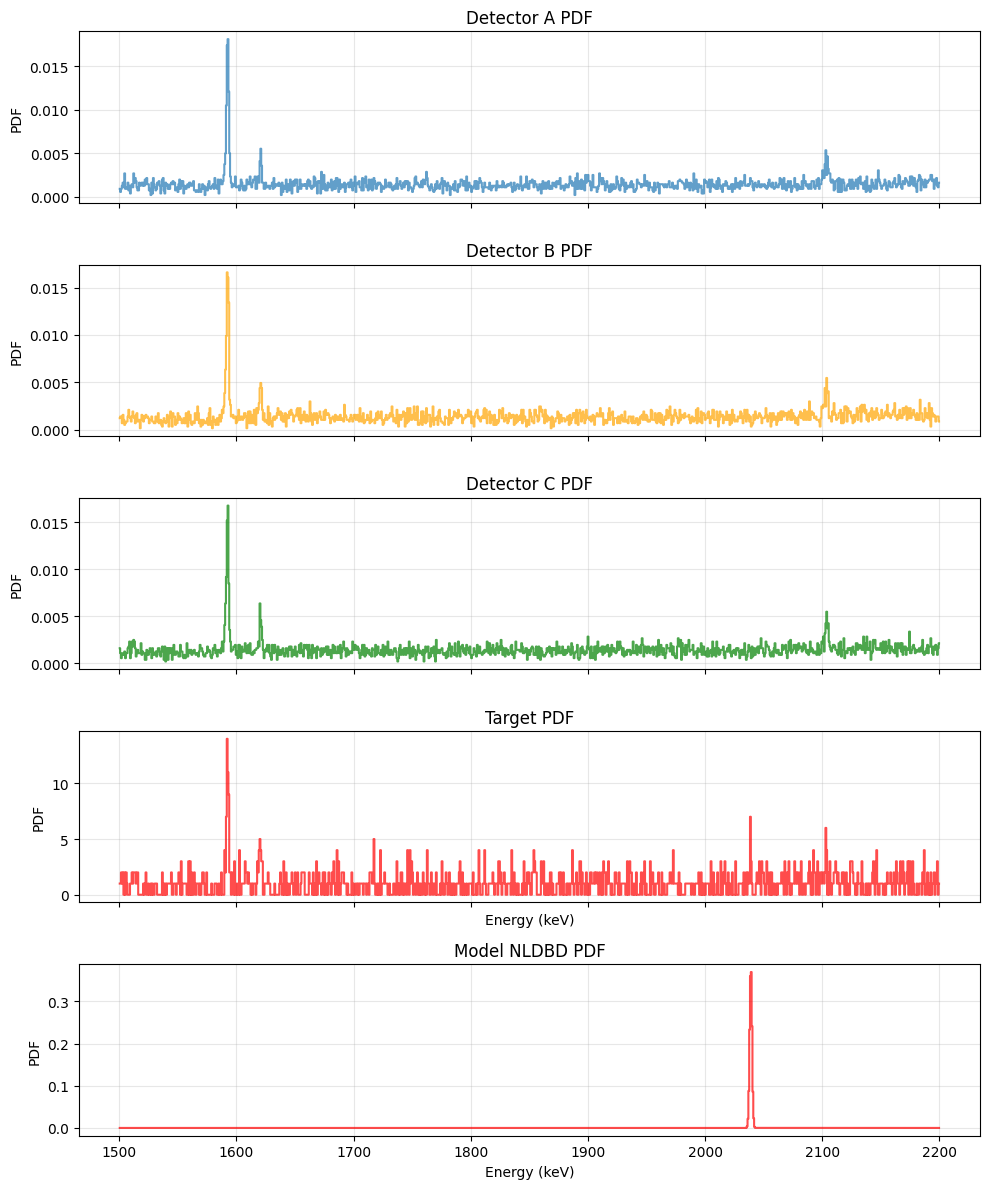

In [18]:
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Detector A
axs[0].step(bin_centers, pdf_A, where='mid', alpha=0.7)
axs[0].set_ylabel("PDF")
axs[0].set_title("Detector A PDF")
axs[0].grid(alpha=0.3)

# Detector B
axs[1].step(bin_centers, pdf_B, where='mid', alpha=0.7, color='orange')
axs[1].set_ylabel("PDF")
axs[1].set_title("Detector B PDF")
axs[1].grid(alpha=0.3)

# Detector C
axs[2].step(bin_centers, pdf_C, where='mid', alpha=0.7, color='green')
axs[2].set_ylabel("PDF")
axs[2].set_title("Detector C PDF")
axs[2].grid(alpha=0.3)

# Target
axs[3].step(bin_centers, detTarget_counts,
            where='mid', alpha=0.7, color='red')
axs[3].set_ylabel("PDF")
axs[3].set_title("Target PDF")
axs[3].set_xlabel("Energy (keV)")
axs[3].grid(alpha=0.3)

# ovbb
axs[4].step(bin_centers, pdf_ovbb,
            where='mid', alpha=0.7, color='red')
axs[4].set_ylabel("PDF")
axs[4].set_title("Model NLDBD PDF")
axs[4].set_xlabel("Energy (keV)")
axs[4].grid(alpha=0.3)
plt.tight_layout()
plt.show()


# 6. Frequentist Fit

In [ ]:
def fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges):
    """
    Fit DetectorTarget histogram with template PDFs and show uncertainties.
    """
    bin_width = bin_edges[1] - bin_edges[0]
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Model chi2 function
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts_Target - model)**2 / (model + 1e-6))  # avoid div0

    def nll(theta_A, theta_B, theta_C, theta_ovbb):
        mu = (theta_A * pdf_A +
              theta_B * pdf_B +
              theta_C * pdf_C +
              theta_ovbb * pdf_ovbb)

        # Avoid log(0)
        mu = np.clip(mu, 1e-12, None)

        # Poisson negative log-likelihood (ignoring ln(n!))
        return 2 * np.sum(mu - counts_Target * np.log(mu))

    # Initial guess
    indA, indB = 1350, 770
    sigmaA, sigmaB = 100, 270
    m = Minuit(nll, theta_A=indA, theta_B=indB, theta_C=100, theta_ovbb=10)
    m.errordef = 1  # chi2
    # m.limits = [(0, None), (0, None), (0, None), (0, None)]
    m.limits = [(indA-2*sigmaA, indA+2*sigmaA), (indB-2*sigmaB, indB+2*sigmaB), (0, None), (0, None)]

    m.migrad()

    # Extract fit values and errors
    theta_fit = m.values
    theta_err = m.errors

    print("Fitted θ values ± 1σ:")
    for i, name in enumerate(['theta_A', 'theta_B', 'theta_C', 'theta_ovbb']):
        print(f"{name} = {theta_fit[i]:.2f} ± {theta_err[i]:.2f}")

    # Model counts
    model_counts = (theta_fit['theta_A']*pdf_A +
                    theta_fit['theta_B']*pdf_B +
                    theta_fit['theta_C']*pdf_C +
                    theta_fit['theta_ovbb']*pdf_ovbb)

    # Setup figure with ratio subplot
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios':[3,1]}, sharex=True)

    # Main histogram
    ax_main.bar(bin_centers, counts_Target, width=bin_width, color='gray', alpha=0.6, label='Data')
    ax_main.step(bin_centers, model_counts, color='red', where='mid', label='Fit')
    ax_main.set_ylabel("Counts / bin")
    ax_main.set_title("DetectorTarget Fit with Template PDFs")
    ax_main.legend()
    ax_main.grid(alpha=0.3)

    # Ratio plot
    mask = counts_Target > 2  # ignore bins with less than 2 counts
    ratio = model_counts[mask] / counts_Target[mask]
    ax_ratio.step(bin_centers[mask], ratio, color='blue', where='mid')
    ax_ratio.axhline(1, color='black', linestyle='--')
    ax_ratio.set_xlabel("Energy (keV)")
    ax_ratio.set_ylabel("Fit / Data")
    ax_ratio.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return theta_fit, theta_err

bounded 
Fitted θ values ± 1σ:
theta_A = 1150.00 ± 0.70
theta_B = 230.00 ± 0.80
theta_C = 0.00 ± 0.61
theta_ovbb = 1.58 ± 2.07

unbounded
Fitted θ values ± 1σ:
theta_A = 158.36 ± 53.58
theta_B = 341.43 ± 50.82
theta_C = 202.20 ± 52.79
theta_ovbb = 6.40 ± 2.56


Fitted θ values ± 1σ:
theta_A = 158.36 ± 53.58
theta_B = 341.43 ± 50.82
theta_C = 202.20 ± 52.79
theta_ovbb = 6.40 ± 2.56


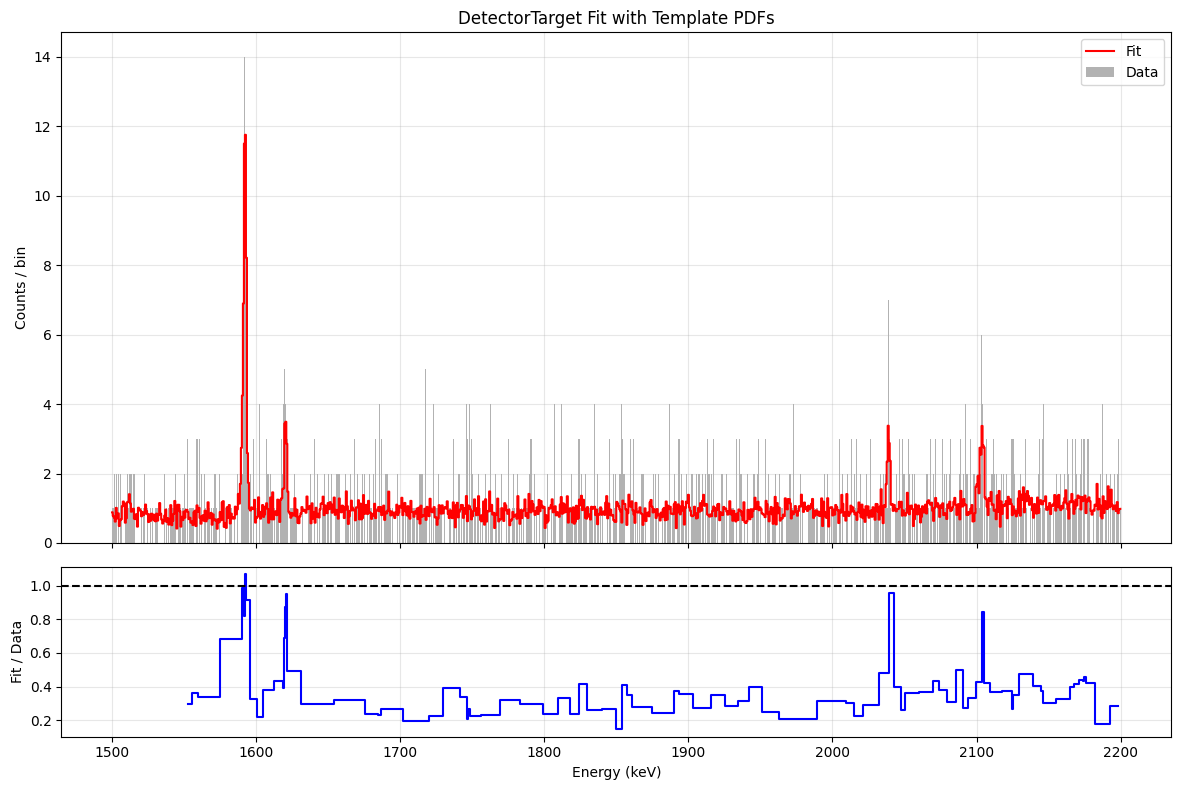

In [27]:
theta_fit, theta_error = fit_detector_target(counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, bin_edges)

# 7. Calculate 90% confidence interval

In [21]:
### Confidence level

from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A +
                 theta_B * pdf_B +
                 theta_C * pdf_C +
                 theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))
    return chi2

def profile_ci_ovbb(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                    best_fit, n_scan=80, max_val=20):
    """
    Compute profile chi2 for theta_ovbb and return 90% CL.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)

    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"],
            )

        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()

        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)

    # best chi2
    chi2_min = np.min(chi2_profile)

    # 90% CL threshold
    delta90 = chi2_min + 2.71

    # Find CI region
    mask = chi2_profile <= delta90
    ci_low = theta_ovbb_values[mask][0]
    ci_high = theta_ovbb_values[mask][-1]

    # Plot
    plt.figure(figsize=(10,5))
    plt.plot(theta_ovbb_values, chi2_profile, '-o', markersize=3)
    plt.axhline(chi2_min, linestyle='--', color='black', label='best fit')
    plt.axhline(delta90, linestyle='--', color='red', label='90% CL')
    plt.xlabel("theta_ovbb")
    plt.ylabel("chi2")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"90% CL interval for θ_ovbb: [{ci_low:.2f}, {ci_high:.2f}]")

    return ci_low, ci_high, theta_ovbb_values, chi2_profile


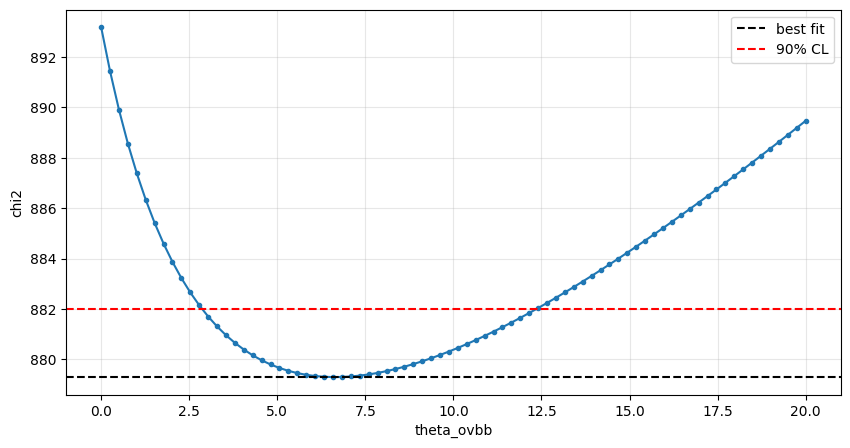

90% CL interval for θ_ovbb: [3.04, 12.15]


In [22]:
ci_low, ci_high, scan_x, scan_chi2 = profile_ci_ovbb(
    counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, theta_fit
)


# 8. Calculate Experimental Sensativity

In [23]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

def chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb):
    """Return a chi2 function for the template fit"""
    def chi2(theta_A, theta_B, theta_C, theta_ovbb):
        model = (theta_A * pdf_A + theta_B * pdf_B + theta_C * pdf_C + theta_ovbb * pdf_ovbb)
        return np.sum((counts - model)**2 / (model + 1e-6))  # avoid div0
    return chi2

def profile_upper_limit(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb,
                        best_fit, n_scan=80, max_val=20):
    """
    Profile chi2 for theta_ovbb (thetaNLDBD) and return 90% CL upper limit.
    """
    chi2_fn = chi2_function(counts, pdf_A, pdf_B, pdf_C, pdf_ovbb)
    theta_ovbb_values = np.linspace(0, max_val, n_scan)
    chi2_profile = []

    for theta_ovbb in theta_ovbb_values:
        def chi(theta_A, theta_B, theta_C):
            return chi2_fn(theta_A, theta_B, theta_C, theta_ovbb)
        m = Minuit(chi,
                   theta_A=best_fit["theta_A"],
                   theta_B=best_fit["theta_B"],
                   theta_C=best_fit["theta_C"])
        m.errordef = 1
        m.limits = [(0,None),(0,None),(0,None)]
        m.migrad()
        chi2_profile.append(m.fval)

    chi2_profile = np.array(chi2_profile)
    chi2_min = np.min(chi2_profile)
    delta90 = chi2_min + 2.71  # 90% CL for one parameter

    # Upper limit is the largest theta_ovbb below the 90% CL threshold
    mask = chi2_profile <= delta90
    upper_limit = theta_ovbb_values[mask][-1]

    return upper_limit

def compute_sensitivity(n_toys, counts_Target, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit):
    """
    Compute the experimental sensitivity (median upper limit) using pseudo-experiments.
    """
    upper_limits = []
    total_counts = best_fit["theta_A"]*pdf_A + best_fit["theta_B"]*pdf_B + best_fit["theta_C"]*pdf_C

    for i in range(n_toys):
        # Generate pseudo-data with Poisson fluctuations under null hypothesis (theta_ovbb=0)
        toy_counts = np.random.poisson(total_counts)
        ul = profile_upper_limit(toy_counts, pdf_A, pdf_B, pdf_C, pdf_ovbb, best_fit)
        upper_limits.append(ul)

    upper_limits = np.array(upper_limits)
    median_sensitivity = np.median(upper_limits)

    # Plot
    plt.figure(figsize=(10,5))
    plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
    plt.axvline(median_sensitivity, color='red', linestyle='--', label='Median Sensitivity')
    plt.xlabel('θNLDBD upper limit at 90% CL')
    plt.ylabel('Number of toys')
    plt.title('Experimental Sensitivity Distribution')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Median 90% CL upper limit (experimental sensitivity): {median_sensitivity:.2f}")

    return upper_limits, median_sensitivity


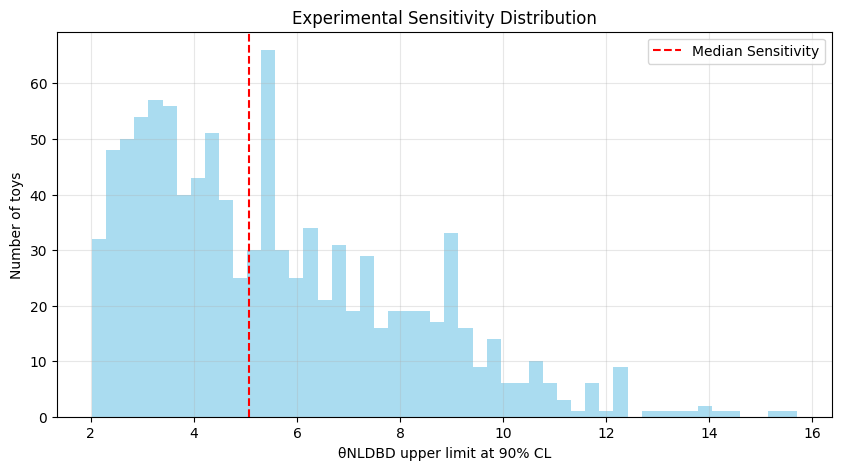

Median 90% CL upper limit (experimental sensitivity): 5.06


In [24]:
n_toys = 1000  # or 1000 for more precise result
upper_limits, median_sens = compute_sensitivity(n_toys,
                                                counts_Target,
                                                pdf_A, pdf_B, pdf_C, pdf_ovbb,
                                                theta_fit)

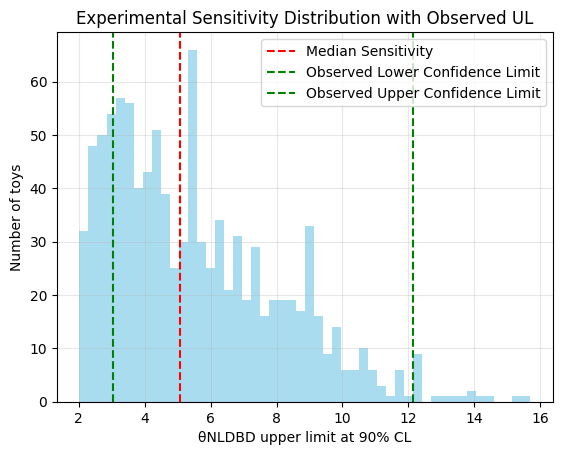

In [25]:
plt.hist(upper_limits, bins=50, alpha=0.7, color='skyblue')
plt.axvline(median_sens, color='red', linestyle='--', label='Median Sensitivity')
plt.axvline(ci_low, color='green', linestyle='--', label='Observed Lower Confidence Limit')
plt.axvline(ci_high, color='green', linestyle='--', label='Observed Upper Confidence Limit')
plt.xlabel('θNLDBD upper limit at 90% CL')
plt.ylabel('Number of toys')
plt.title('Experimental Sensitivity Distribution with Observed UL')
plt.legend()
plt.grid(alpha=0.3)
plt.show()
